In [7]:
%cd /home/michele/projects/nlp-hw1/hw1

/home/michele/projects/nlp-hw1/hw1


In [8]:
import random
import string
from dataclasses import dataclass

import numpy as np
import torch
from torch import nn

from stud.datasets.lstm_dataset import WiCDataset, read_data
from stud.datasets.pos import pos_all_tags
from stud.models import (
    BilinearClassifier,
    LstmBilinearClassifier,
    LstmClassifier,
    MlpClassifier,
    LstmBilinearClassifier,
)
from stud.trainer import fit
from stud.utils import (
    Checkpoint,
    config_wandb,
    embeddings_dictionary,
    index_dictionary,
    word_vectors_most_common,
    load_pickle
)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/michele/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/michele/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [9]:
path = '../data/dev.jsonl'
weights_path = "../model/002.pth"
vocab_path = "../model/vocabulary.pkl"

In [14]:
@dataclass
class Args:
    # wandb
    save_wandb = False
    device = "cpu"#"cuda" if torch.cuda.is_available() else "cpu"

    # general parameters
    num_epochs = 15
    batch_size = 64
    lr = 0.0001
    weight_decay = 0.0001
    vocab_threshold = 0
    sentence_embedding_size = 300

    # dataset parameters
    save_labels = True
    remove_stopwords = True
    remove_digits = True
    remove_target_word = False
    target_window = None

    # model parameters
    model_type = "BILINEAR"
    use_pretrained_embeddings = True
    use_pos = False

    # MLP Parameters
    if model_type == "MLP":
        mlp_n_features = 300
        mlp_num_layers = 0
        mlp_n_hidden = 512
        mlp_dropout = 0.3

    # LSTM Parameters
    if model_type == "LSTM":
        sentence_embedding_size = 300
        linear_dropout = 0.3
        sentence_n_hidden = 512
        sentence_num_layers = 4
        sentence_bidirectional = True
        sentence_dropout = 0.3
    
    # LSTM with bilinear Parameters
    if model_type == "BILSTM":
        sentence_embedding_size = 300
        linear_dropout = 0.3
        sentence_n_hidden = 512
        sentence_num_layers = 2
        sentence_bidirectional = True
        sentence_dropout = 0.3

    if model_type == "BILINEAR":
        bi_n_features = 300
        bi_n_hidden = 400
        bi_dropout = 0.3

    # POS parameters
    if use_pos:
        pos_embedding_size = 300
        pos_vocab_size = len(pos_all_tags)
        if model_type == "LSTM":
            pos_n_hidden = 256
            pos_num_layers = 2
            pos_bidirectional = True
            pos_dropout = 0.3

# args for dataset and model
args = Args()
# vocabulary
word_vectors = load_pickle(vocab_path)
# vocabulary with indexes
word_index, vectors_store = index_dictionary(word_vectors)

# model definition
model = BilinearClassifier(vectors_store, args).to(
    args.device
)

# load model weights
weights = torch.load(weights_path, map_location=args.device)
model.load_state_dict(weights["model_state_dict"])
model.eval()



BilinearClassifier(
  (embedding): Embedding(400002, 300, padding_idx=0)
  (bilinear_layer): Bilinear(in1_features=300, in2_features=300, out_features=400, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=400, out_features=400, bias=True)
  (last_layer): Linear(in_features=400, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [18]:
import string
import random
from torch.utils.data import DataLoader
marker = "".join(random.choices(string.ascii_lowercase, k=20))

In [21]:
from typing import *
def batch_to_device(batch: Dict[str, torch.Tensor], device: str) -> List[torch.Tensor]:
    return {key: value.to(device) for key, value in batch.items()}

In [129]:
data = read_data(path)
dataset = WiCDataset(data, word_index, marker, args)
loader = DataLoader(dataset, batch_size=32, shuffle=False)
predicted = []
for batch in loader:
    batch = batch_to_device(batch, args.device)
    pred = model(batch).round()
    predicted.append(pred)
# predicted = torch.stack(predicted, dim=0)

In [126]:
ground_truth = np.array([dataset[i]['label'].item() for i in range(len(dataset))])
predictions = torch.cat(predicted).detach().numpy()


In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [142]:
cm = confusion_matrix(ground_truth, predictions)

In [143]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

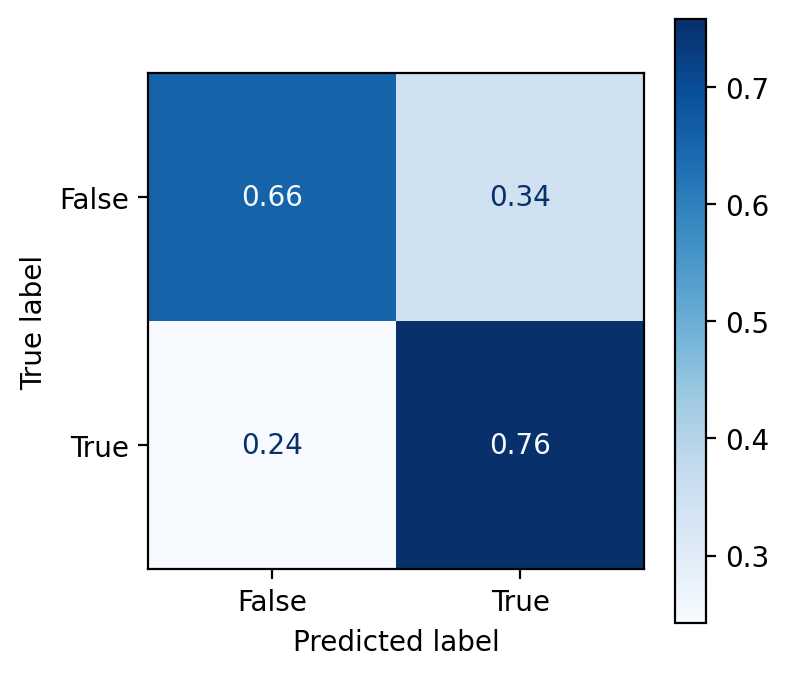

In [144]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
ConfusionMatrixDisplay(cm_norm, display_labels=['False', 'True']).plot(cmap='Blues', ax=ax)

plt.show()

In [13]:
import matplotlib.pyplot as plt

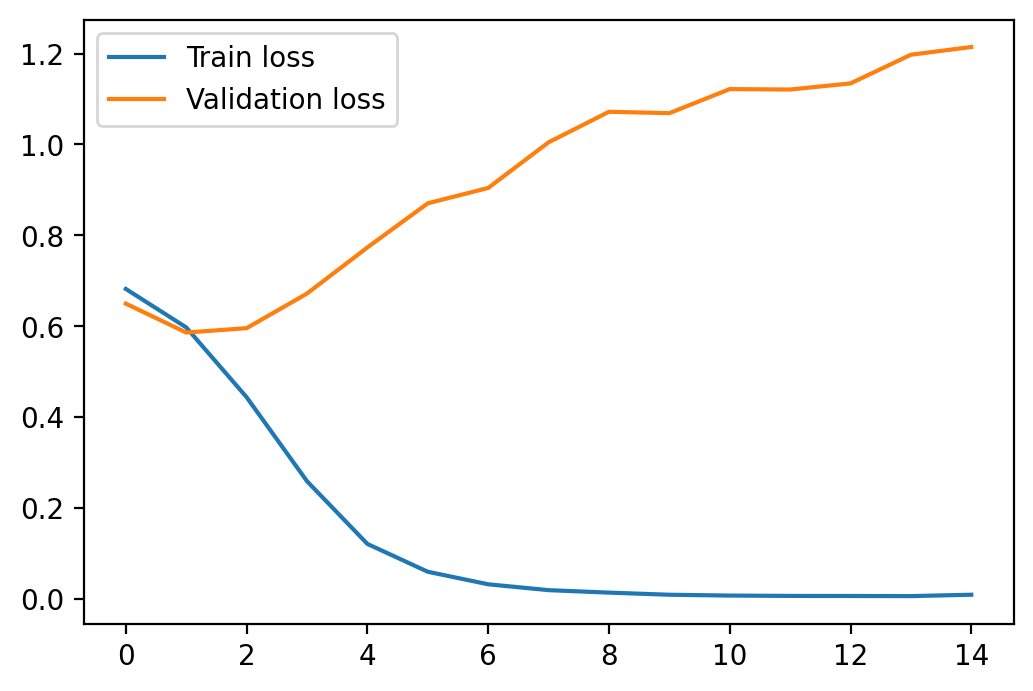

In [33]:
bilinear_losses = load_pickle('stud/loss.pkl')

train_loss = bilinear_losses['train']

val_loss = bilinear_losses['val']

fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

ax.plot(train_loss[:15], label='Train loss')
ax.plot(val_loss[:15], label='Validation loss')
ax.legend()

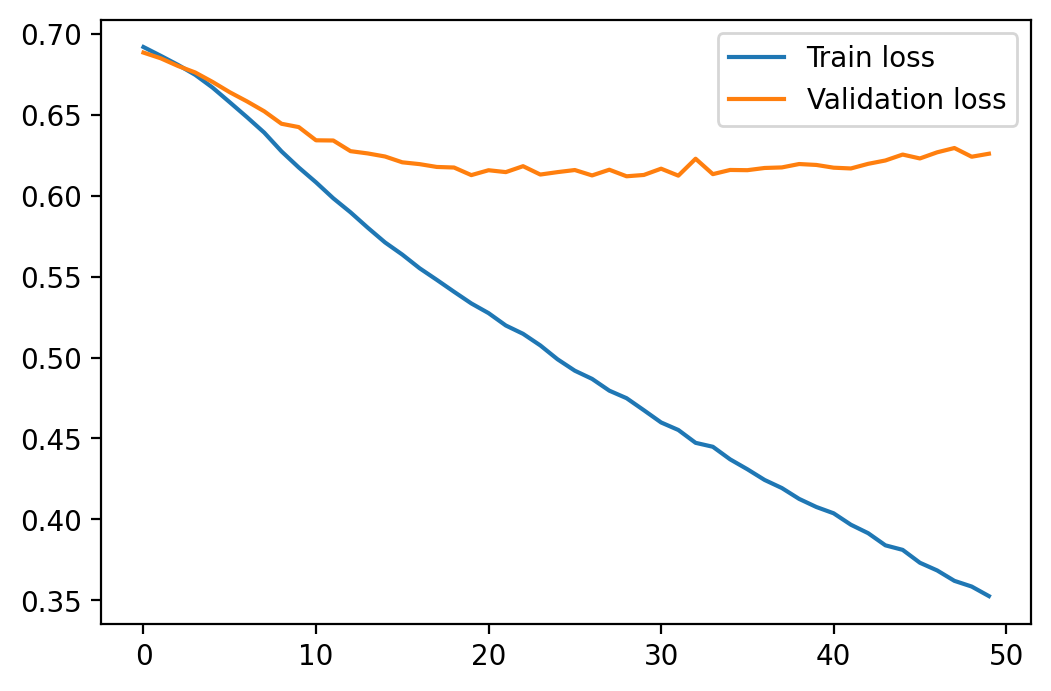

In [36]:
mlp_losses = load_pickle('stud/mlp_loss.pkl')

train_loss = mlp_losses['train']

val_loss = mlp_losses['val']

fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

ax.plot(train_loss, label='Train loss')
ax.plot(val_loss, label='Validation loss')
ax.legend()
plt.show()